Alright we are going to try and detect brain tumors. First we load pytorch, torchvision and some other libraries we need.

In [20]:
from transformers import AutoFeatureExtractor, ResNetForImageClassification
import torch
from torchvision import datasets,transforms
import torchvision
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

Next we are going to load and transform our dataset. Here is what's important. I've resized and centered mine to 128x128. All you data and images need to be in the same size. You can do other things here like change the greyscale or cut out some colors. This is going to be a key to tuning this model, is figuring out the optimal normization for the images. Changing these sizes will require small changes to our model as well.

We load a test and train set. We need to train and validate and they can't be the same. We also need to our labels for the data.

In [21]:

transform = transforms.Compose([transforms.Resize(128),
                                 transforms.CenterCrop(128),
                                 transforms.ToTensor()])
training_dataset = datasets.ImageFolder('archive/Training', transform=transform)
testing_dataset = datasets.ImageFolder('archive/Testing', transform=transform)

# Class labels
classes = ('glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor')

We are going to load our training and test data and pick our batch size. Batch size is an important hyper parameter that will affect how fast our gradient descent converges or if it will at all. In our case this is 4 images at a time.

In [22]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=4, shuffle=True)

The below code allows us to see the images from our training set and validate their labels.

pituitary_tumor  pituitary_tumor  pituitary_tumor  no_tumor


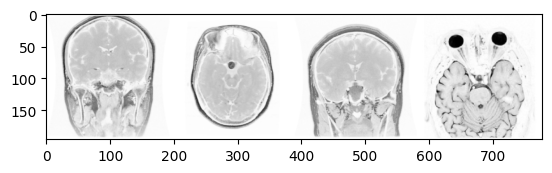

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

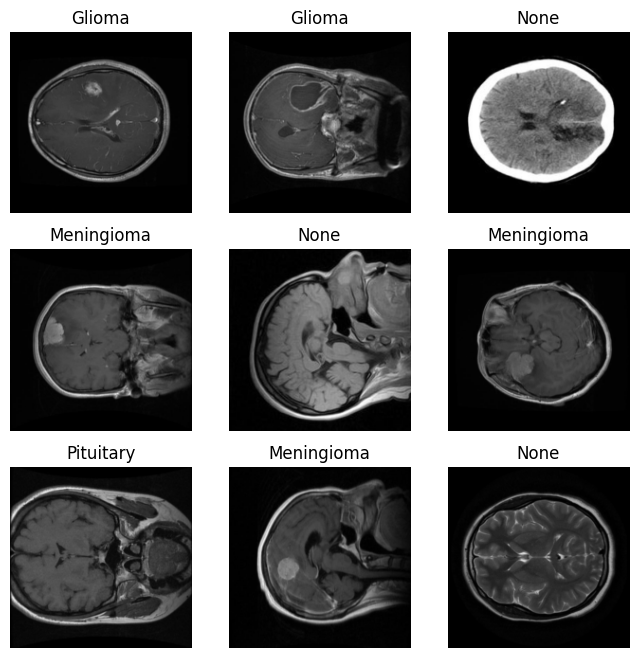

In [24]:
labels_map = {
    0: "Glioma",
    1: "Meningioma",
    2: "None",
    3: "Pituitary"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.T, cmap="gray")
plt.show()

Ok we are going to seperate our images into batches and displays their labels.

In [25]:
for batch_number, (images, labels) in enumerate(training_loader):
    print(batch_number, labels)

0 tensor([1, 2, 3, 1])
1 tensor([2, 0, 0, 0])
2 tensor([3, 1, 1, 1])
3 tensor([2, 1, 2, 1])
4 tensor([1, 2, 0, 0])
5 tensor([2, 3, 1, 1])
6 tensor([2, 0, 1, 2])
7 tensor([3, 0, 0, 0])
8 tensor([0, 0, 0, 2])
9 tensor([2, 2, 1, 3])
10 tensor([0, 0, 3, 3])
11 tensor([1, 3, 0, 1])
12 tensor([3, 3, 1, 1])
13 tensor([0, 3, 3, 1])
14 tensor([0, 1, 1, 3])
15 tensor([1, 3, 3, 2])
16 tensor([0, 0, 2, 3])
17 tensor([0, 1, 0, 2])
18 tensor([0, 3, 1, 0])
19 tensor([2, 3, 3, 0])
20 tensor([1, 0, 1, 1])
21 tensor([3, 1, 3, 2])
22 tensor([0, 1, 1, 3])
23 tensor([0, 0, 0, 0])
24 tensor([0, 1, 3, 3])
25 tensor([3, 0, 2, 1])
26 tensor([0, 3, 0, 3])
27 tensor([2, 3, 2, 1])
28 tensor([3, 3, 3, 3])
29 tensor([0, 0, 2, 0])
30 tensor([3, 0, 3, 1])
31 tensor([3, 0, 0, 3])
32 tensor([3, 3, 3, 0])
33 tensor([1, 0, 0, 0])
34 tensor([2, 0, 1, 1])
35 tensor([2, 0, 3, 1])
36 tensor([2, 0, 3, 0])
37 tensor([1, 0, 3, 0])
38 tensor([0, 2, 2, 3])
39 tensor([3, 3, 0, 1])
40 tensor([0, 2, 1, 2])
41 tensor([2, 1, 0, 1])
42

This chooses to either use CUDA which is for nvidia GPUs or your local devices. My macbook air was able to run this model and training with it's built in GPU but image size and batch size can easily run this thing out of memory.

In [26]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


This is our first model we developed just to test it all out. It took 128x128 pixels however and won't run with the above transformations.

This produced 68% accuracy with 20 epochs of training and a .001 lr with momentum of .9 and SGD optimizer.

In [27]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class TumorClassifier(nn.Module):
    def __init__(self):
        super(TumorClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4*56*56,120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = TumorClassifier()

Below is the actual CNN - the neural network. I'm not going to explain how all these numbers work, I'm still learning exactly when and how to tune them myself. Ultimately these deterime the amount of input and output channels and the amount of layers in between where learning occurs. All of the numbers must match up mathmatelically for a functioning neural network. For example changing the batch and/or image size would affect all of this.

This CNN model produces ~73% accuracy with 20 epochs of training and a .001 lr with momentum of .9 and SGD optimizer.

In [28]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class TumorClassifier(nn.Module):
    def __init__(self):
        super(TumorClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       # self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv6 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv7 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4*192*192,1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = TumorClassifier()

This is an experimental model based on VGG19. It's not working as well as the other models however it required a much large fully connected layer we couldn't run on our computers.

In [15]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class TumorClassifier(nn.Module):
    def __init__(self):
        super(TumorClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       # self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv6 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv7 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv9 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv10 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv11 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4*18432,2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = self.pool(x)
        x = F.relu(self.conv10(x))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = TumorClassifier()

Setting up our loss function and confirming it works on some dummy data.

In [29]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(2, 4)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 3])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.4970, 0.3626, 0.7769, 0.3473],
        [0.4598, 0.7927, 0.4486, 0.5445]])
tensor([1, 3])
Total loss for this batch: 1.4741804599761963


Time to train! This is programmed to train for 10 epochs (cycles) and print out every 200 batches how our loss is perfomring. It should, for the most part continue to decrease. The lower the better, but once it starts to increase your going in the wrong direction and have put to many cycles in.

In [31]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = 'model_{}'.format(timestamp)
torch.save(model.state_dict(), model_path)

KeyboardInterrupt: 

Now that we have our model trained and saved, we need to see how it performs.

Just like we did with the training data, we are going to do with the validation data. Make sure the images and lables are correct.

no_tumor  pituitary_tumor  glioma_tumor  glioma_tumor


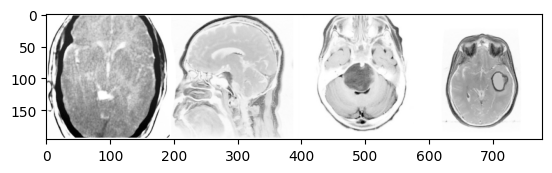

In [257]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(validation_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

Now the fun part, now we load our network and model and we run a prediction on this same data. Amazingly, they are all the same 4/4. The model works!!

In [258]:
net = TumorClassifier()
net.load_state_dict(torch.load(model_path, weights_only=True))
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  meningioma_tumor pituitary_tumor meningioma_tumor no_tumor


How good is the model overall? We're going to test it on our entire validation set and see!

Currently, first run, no tuning, just messing around, it's at 68%... pure chance is 25%, so doing pretty good! We can probably make it much better. More to come.

In [259]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 70 %
